## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten

### Load Data

In [2]:
# Read the JSON file
with open('Sarcasm_Headlines_Dataset.json', 'r') as f:
    data = [json.loads(line) for line in f]

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (28619, 3)


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
# Check class distribution
print("Class distribution:")
print(df['is_sarcastic'].value_counts())
print(f"Percentage of sarcastic headlines: {df['is_sarcastic'].mean() * 100:.2f}%")

Class distribution:
is_sarcastic
0    14985
1    13634
Name: count, dtype: int64
Percentage of sarcastic headlines: 47.64%


### Drop `article_link` from dataset

In [4]:
# Drop the article_link column
df = df.drop('article_link', axis=1)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


### Get length of each headline and add a column for that

Headline length statistics:
count    28619.000000
mean        10.049967
std          3.388307
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max        151.000000
Name: headline_length, dtype: float64


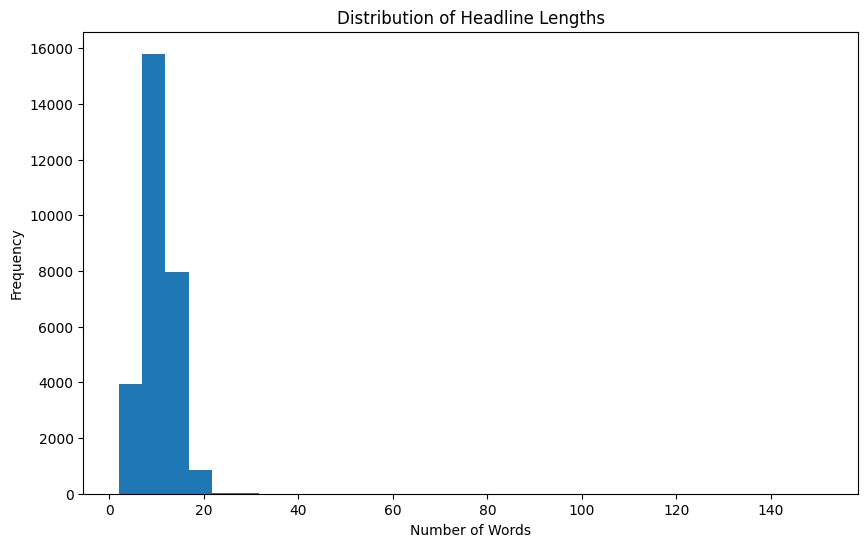

In [5]:
# Calculate the length of each headline
df['headline_length'] = df['headline'].apply(lambda x: len(x.split()))

# Display statistics of headline length
print("Headline length statistics:")
print(df['headline_length'].describe())

# Visualize the distribution of headline lengths
plt.figure(figsize=(10, 6))
plt.hist(df['headline_length'], bins=30)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

### Initialize parameter values
- max_features: Number of words to take from tokenizer (most frequent words)
- maxlen: Maximum length of each sentence to be limited to 25
- embedding_size: size of embedding vector

In [6]:
max_features = 10000
maxlen = 25
embedding_size = 50  # Using 50d GloVe embeddings

### Apply `tensorflow.keras` Tokenizer and get indices for words
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence

In [7]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_features)

# Fit the tokenizer on the headlines
tokenizer.fit_on_texts(df['headline'])

# Convert headlines to sequences
sequences = tokenizer.texts_to_sequences(df['headline'])

# Display a sample headline and its sequence
sample_idx = 0
print(f"Original headline: {df['headline'][sample_idx]}")
print(f"Tokenized sequence: {sequences[sample_idx]}")

Original headline: thirtysomething scientists unveil doomsday clock of hair loss
Tokenized sequence: [354, 3166, 7473, 2643, 2, 660, 1118]


### Pad sequence
- Pad each example with a maximum length
- Convert target column into numpy array

In [8]:
# Pad the sequences
X = pad_sequences(sequences, maxlen=maxlen)

# Convert target to numpy array
y = np.array(df['is_sarcastic'])

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Display a sample padded sequence
print(f"\nPadded sequence for sample headline: {X[sample_idx]}")

X shape: (28619, 25)
y shape: (28619,)

Padded sequence for sample headline: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  354 3166 7473 2643    2  660 1118]


### Vocab mapping
- There is no word for 0th index

In [9]:
# Get the word index mapping
word_index = tokenizer.word_index
print(f"Total unique words: {len(word_index)}")

# Display a few word-index mappings
print("\nSample word-index mappings:")
items = list(word_index.items())[:10]
for word, idx in items:
    print(f"{word}: {idx}")

Total unique words: 30884

Sample word-index mappings:
to: 1
of: 2
the: 3
in: 4
for: 5
a: 6
on: 7
and: 8
with: 9
is: 10


### Set number of words
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [10]:
# Calculate vocabulary size (add 1 for the 0th index which is reserved for padding)
vocab_size = min(max_features, len(word_index) + 1)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 10000


### Load Glove Word Embeddings

In [11]:
# Load GloVe embeddings
embeddings_index = {}
with open('glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors in GloVe.")

Found 400000 word vectors in GloVe.


### Create embedding matrix

In [12]:
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector

# Calculate how many words from our vocabulary are found in GloVe
found_words = 0
for i in range(1, vocab_size):
    if np.sum(embedding_matrix[i]) > 0:
        found_words += 1
        
print(f"Found embeddings for {found_words} words out of {vocab_size-1} words in vocabulary.")
print(f"Coverage: {found_words/(vocab_size-1)*100:.2f}%")

Found embeddings for 5411 words out of 9999 words in vocabulary.
Coverage: 54.12%


### Split the data into training and validation sets

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (22895, 25)
Validation set shape: (5724, 25)


### Define model
- Using Sequential model with Embedding layer, Bidirectional LSTM, and Dense layers

In [14]:
# Define the model
model = Sequential()

# Add Embedding layer with pre-trained weights
model.add(Embedding(vocab_size, embedding_size, 
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))

# Add Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=True)))

# Add another Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32)))

# Flatten the output
model.add(Flatten())

# Add Dense layer with dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Display model summary
model.summary()

c:\Users\Deepan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

### Compile the model

In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Fit the model

In [16]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.6471 - loss: 0.6215 - val_accuracy: 0.7888 - val_loss: 0.4497
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7948 - loss: 0.4415 - val_accuracy: 0.8206 - val_loss: 0.3927
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8307 - loss: 0.3780 - val_accuracy: 0.8297 - val_loss: 0.3701
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8510 - loss: 0.3439 - val_accuracy: 0.8374 - val_loss: 0.3575
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8616 - loss: 0.3212 - val_accuracy: 0.8384 - val_loss: 0.3675
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8746 - loss: 0.2931 - val_accuracy: 0.8454 - val_loss: 0.3403
Epoch 7/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8871 - loss: 0.2663 - val_accuracy: 0.8393 - val_loss: 0.3705
Epoch 8/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.8902 - loss: 0.2574 - v

### Evaluate the model

In [17]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8523 - loss: 0.3265
Validation Loss: 0.3403
Validation Accuracy: 0.8454


### Plot training history

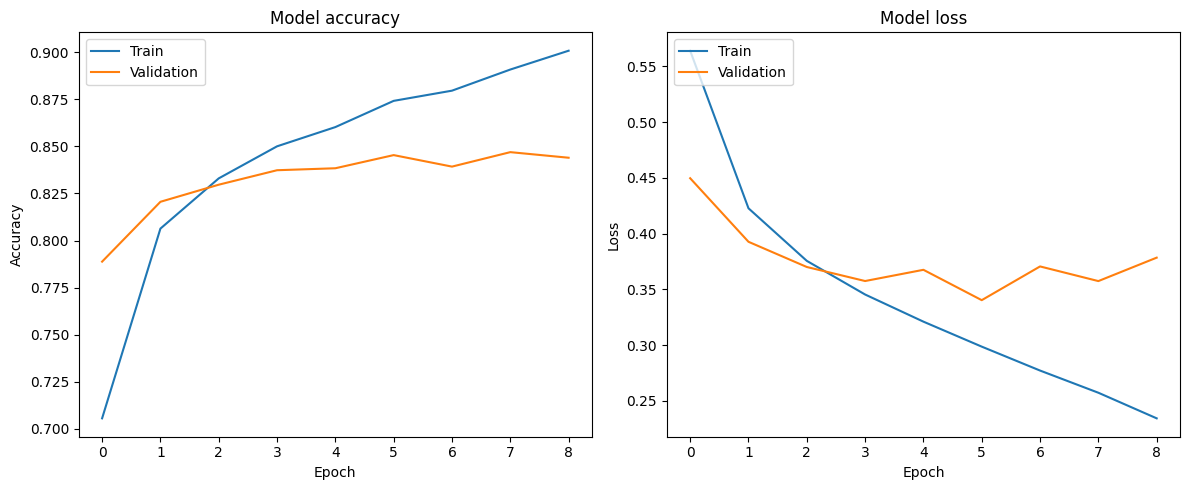

In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Test with some examples

In [19]:
# Function to predict sarcasm in a headline
def predict_sarcasm(headline):
    # Tokenize and pad the headline
    sequence = tokenizer.texts_to_sequences([headline])
    padded = pad_sequences(sequence, maxlen=maxlen)
    
    # Make prediction
    prediction = model.predict(padded)[0][0]
    
    return {
        'headline': headline,
        'prediction': 'Sarcastic' if prediction > 0.5 else 'Not Sarcastic',
        'confidence': prediction if prediction > 0.5 else 1 - prediction
    }

# Test with some examples
test_headlines = [
    "scientists discover cure for cancer",
    "local man decides to try eating healthy for once",
    "area dad completely fine with just getting socks for father's day",
    "new study shows benefits of regular exercise",
    "breaking news: politician actually keeps campaign promise"
]

for headline in test_headlines:
    result = predict_sarcasm(headline)
    print(f"Headline: {result['headline']}")
    print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.2f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
Headline: scientists discover cure for cancer
Prediction: Sarcastic (Confidence: 0.83)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Headline: local man decides to try eating healthy for once
Prediction: Sarcastic (Confidence: 0.99)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Headline: area dad completely fine with just getting socks for father's day
Prediction: Sarcastic (Confidence: 1.00)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Headline: new study shows benefits of regular exercise
Prediction: Sarcastic (Confidence: 0.97)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Headline: breaking news: politician actually keeps campaign promise
Prediction: Sarcastic (Confidence: 0.86)

